ФИО: Нагорянский Олег Николаевич
ТГ: Y0Gin

<h1> Прогнозирование будущего компаний стартапов</h1>

Цель: 
<br/>
🔸Разработать модель машинного обучения для предсказания продолжения деятельности стартапа. 
<br/>
🔸Провести полноценный разведочный анализ и сформировать рекомендации будущим создателям стартапов (какие факторы влияют на успешность стартапа).
<br/>
Задачи:
<br/>загрузка и ознакомление с данными,
<br/>предварительная обработка,
<br/>полноценный разведочный анализ,
<br/>разработка новых синтетических признаков,
<br/>проверка на мультиколлинеарность,
<br/>отбор финального набора обучающих признаков,
<br/>выбор и обучение моделей,
<br/>итоговая оценка качества предсказания лучшей модели,
<br/>анализ важности ее признаков,
<br/>подготовка отчета по исследованию.

Описание данных:
<br/>kaggle_startups_train_01.csv - информация (53 000) стартапах, которые будут использоваться в качестве обучающих данных.
<br/>kaggle_startups_test_01.csv - информация (13 000) стартапах, которые будут использоваться в качестве тестовых данных. 
<br/>kaggle_startups_sample_submit_01.csv - файл с примером предсказаний в правильном формате.
<br/>name - идентификатор (название) стартапа в тестовом наборе.
<br/>status - целевой признак. Для каждого стартапа предсказать категориальное значение соответствующее прогнозу ['operating', 'closed'].

Описание полей:
<br/>name - Название стартапа
<br/>category_list - Список категорий, к которым относится стартап
<br/>funding_total_usd - Общая сумма финансирования в USD
<br/>status - Статус стартапа (закрыт или действующий)
<br/>country_code - Код страны
<br/>state_code - Код штата
<br/>region - Регион
<br/>city - Город
<br/>funding_rounds - Количество раундов финансирования
<br/>founded_at - Дата основания
<br/>first_funding_at - Дата первого раунда финансирования
<br/>last_funding_at - Дата последнего раунда финансирования
<br/>closed_at - Дата закрытия стартапа (если применимо)
<br/>lifetime - Время существования стартапа в днях


In [647]:
!pip install phik -q
!pip install shap -q
!pip install -U scikit-learn

In [648]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
import phik
from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler, 
    LabelEncoder,
    FunctionTransformer)
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    confusion_matrix,
    recall_score,
    precision_score
)
from sklearn.compose import ColumnTransformer

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score, f1_score

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.svm import SVC

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем нужные классы
from sklearn.pipeline import Pipeline

from scipy import stats as st
import scipy.stats as sps
import shap

In [649]:
from datetime import date, datetime

<h2>Загрузка данных</h2>

In [650]:
df_train = pd.read_csv('kaggle_startups_train_28062024.csv')

In [651]:
df_test = pd.read_csv('kaggle_startups_test_28062024.csv')

In [652]:
df_train.head(10)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN
5,Connected Sports Ventures,Mobile,4300000.0,operating,USA,NJ,Newark,Princeton,1,2011-04-16,2012-11-12,2012-11-12,NaN
6,Attensity,Analytics|Business Analytics|Social CRM|Social...,90000000.0,operating,USA,CA,SF Bay Area,Redwood City,1,2000-01-01,2014-05-14,2014-05-14,NaN
7,Mesh Networks,Software,4300000.0,operating,USA,TX,Houston,Houston,1,2005-01-01,2014-11-09,2014-11-09,NaN
8,AngioScore,Biotechnology,42000000.0,operating,USA,CA,SF Bay Area,Fremont,2,2003-01-01,2007-10-09,2011-04-20,NaN
9,Vidatronic,Semiconductors,1250500.0,operating,USA,TX,Austin,College Station,2,2010-01-01,2011-08-23,2013-03-21,NaN


df_test.head(10)

In [653]:
df_train.columns

Index(['name', 'category_list', 'funding_total_usd', 'status', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'founded_at',
       'first_funding_at', 'last_funding_at', 'closed_at'],
      dtype='object')

In [654]:
df_test.columns

Index(['name', 'category_list', 'funding_total_usd', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'first_funding_at',
       'last_funding_at', 'lifetime'],
      dtype='object')

Данные из таблиц kaggle_startups_train_28062024.csv, kaggle_startups_test_28062024.csv загружены в переменные типа DataFrame библиотеки Pandas. Состав полей таблиц соответствует описанию данных в проекте.

<h2>Предобработка данных</h2>

<h3>Общая информация</h3>

In [655]:
def data_info(data, data_name):
    print("Информация о столбцах таблицы ", data_name)
    display(data.info())
    print("Количество незаполненных значений в полях:")
    print(data.isna().sum())
    dupl = data.duplicated().sum()
    print("Количество дубликатов:", dupl) 

In [656]:
def to_lower_case(data, list_cols):
    for col in list_cols:
        data[col] = data[col].apply(str.lower)
    return data

In [657]:
data_info(df_train, 'Тренировочная выборка')

Информация о столбцах таблицы  Тренировочная выборка
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


None

Количество незаполненных значений в полях:
name                     1
category_list         2465
funding_total_usd    10069
status                   0
country_code          5502
state_code            6763
region                6359
city                  6359
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at            47599
dtype: int64
Количество дубликатов: 0


In [658]:
df_train['founded_at'] = pd.to_datetime(df_train['founded_at'] )

In [659]:
df_train['first_funding_at'] = pd.to_datetime(df_train['first_funding_at'] )

In [660]:
df_train['last_funding_at'] = pd.to_datetime(df_train['last_funding_at'] )

In [661]:
df_train['closed_at'] = pd.to_datetime(df_train['closed_at'] )

In [662]:
cols = ['category_list', 'status', 'country_code', 'region', 'city', 'funding_rounds']

In [663]:
df_train['status'].value_counts()

operating    47599
closed        4917
Name: status, dtype: int64

In [664]:
df_train['country_code'].value_counts()

USA    29702
GBR     2925
CAN     1540
IND     1276
CHN     1240
       ...  
PSE        1
SEN        1
UZB        1
GRD        1
ZMB        1
Name: country_code, Length: 134, dtype: int64

In [665]:
df_train['region'].value_counts()

SF Bay Area            6970
New York City          2776
Boston                 1890
London                 1840
Los Angeles            1513
                       ... 
Helena                    1
Castelfranco Veneto       1
Taunton                   1
Vevey                     1
Doncaster                 1
Name: region, Length: 1036, dtype: int64

In [666]:
df_train['city'].value_counts()

San Francisco    2824
New York         2486
London           1514
Austin            609
Palo Alto         607
                 ... 
Beppu               1
Idukki              1
Reutlingen          1
Sulphur             1
Centreville         1
Name: city, Length: 4477, dtype: int64

In [667]:
df_train['funding_rounds'].value_counts()

1     33489
2      9816
3      4450
4      2189
5      1168
6       616
7       341
8       175
9       109
10       63
11       46
12       22
13        9
16        6
15        5
14        5
17        3
18        3
19        1
Name: funding_rounds, dtype: int64

In [668]:
data_info(df_test, 'Тестовая выборка')

Информация о столбцах таблицы  Тестовая выборка
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


None

Количество незаполненных значений в полях:
name                    0
category_list         591
funding_total_usd    2578
country_code         1382
state_code           1695
region               1589
city                 1587
funding_rounds          0
first_funding_at        0
last_funding_at         0
lifetime                0
dtype: int64
Количество дубликатов: 0


In [669]:
df_test['first_funding_at'] = pd.to_datetime(df_test['first_funding_at'] )

In [670]:
df_test['last_funding_at'] = pd.to_datetime(df_test['last_funding_at'] )

Исходя из первичного анализа значений датафреймов, видны незаполненные поля в таблицах, также присутствует значительнео число различных категорий и стран. Поля со значениями дат в датафреймах изменены на типы dataframe.

<h3>Предобработка категорий</h3>

In [671]:
def def_category(lst_cat, cat_rating, rating=500):
    category = "unknown"
    for cat in lst_cat:
        cat = cat.strip()
        if (cat in cat_rating.keys()):
            if (cat_rating[cat] > rating):
                rating = cat_rating[cat]
                category = cat
    return category

In [672]:
def def_second_category(lst_cat, cat_rating, rating=500):
    category = def_category(lst_cat, cat_rating, rating)
    if (category == 'unknown'):
        return 'unknown'
    else:
        if (category in lst_cat):
            lst_cat.remove(category)         
    return def_category(lst_cat, cat_rating, rating)

In [673]:
def make_rating(df, df_):
    sr_df = pd.concat([df['category_list'], df_['category_list']])
    
    sr_df = df['category_list']
    sr_df = sr_df.fillna('unknown')
    sr_df = (sr_df
            .str.replace("&", "|", regex = True)
            .str.replace("-", "", regex = True) 
            .str.replace("+", "|", regex = True)
            .str.strip()
            .apply(str.lower))
    div_symb = "|"
    lst_cat = sr_df.str.split(div_symb)
    cmnlst = list()
    for lst in lst_cat:
        cmnlst = cmnlst + lst
    sr_cat = pd.Series(cmnlst).apply(str.strip)  
    cat_rating = sr_cat.value_counts()
    return cat_rating 

In [674]:
def pre_categories(df, cat_rating):
    df['category_list'] = df['category_list'].fillna('Unknown')
    df['category_list'] = (df['category_list']
            .str.replace("&", "|", regex = True)
            .str.replace("-", "", regex = True) 
            .str.replace("+", "|", regex = True)
            .str.strip()
            #.str.replace(' ', '')
            .apply(str.lower))
    div_symb = "|"
    lst_cat = df['category_list'].str.split(div_symb) 
    df['category_list'] = lst_cat.apply(def_category, args=(cat_rating,500))    
    df['sec_category_list'] = lst_cat.apply(def_second_category, args=(cat_rating,2000))
    return df

In [675]:
df_train['category_list'].value_counts().head(10)

Software               3207
Biotechnology          2905
E-Commerce             1064
Mobile                  920
Clean Technology        892
Curated Web             853
Health Care             744
Hardware + Software     733
Games                   681
Enterprise Software     671
Name: category_list, dtype: int64

In [676]:
cat_rating = make_rating(df_train, df_test)

In [677]:
df_train = pre_categories(df_train, cat_rating)

In [678]:
df_test = pre_categories(df_test, cat_rating)

In [679]:
df_train['category_list'].value_counts()

software                  8154
unknown                   8003
mobile                    3928
biotechnology             3654
ecommerce                 2993
curated web               2108
enterprise software       1658
health care               1523
social media              1481
games                     1405
advertising               1286
clean technology          1135
education                 1054
finance                    995
health and wellness        955
manufacturing              883
internet                   820
analytics                  717
technology                 712
services                   604
security                   547
real estate                491
consulting                 483
travel                     472
semiconductors             451
apps                       448
saas                       441
hospitality                428
medical                    372
fashion                    365
web hosting                338
marketplaces               318
financia

In [680]:
df_test['category_list'].value_counts()

unknown                   2020
software                  1995
mobile                    1000
biotechnology              867
ecommerce                  748
curated web                534
health care                390
enterprise software        384
games                      383
social media               373
advertising                311
clean technology           304
education                  292
finance                    252
health and wellness        246
manufacturing              239
internet                   200
technology                 196
analytics                  181
services                   167
security                   132
travel                     123
consulting                 121
real estate                120
hospitality                116
fashion                    105
semiconductors             104
saas                       103
medical                     97
web hosting                 96
apps                        89
marketplaces                74
financia

In [681]:
display(df_train.head())

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,sec_category_list
0,Lunchgate,unknown,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT,unknown
1,EarLens,manufacturing,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT,unknown
2,Reviva Pharmaceuticals,biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT,unknown
3,Sancilio and Company,health care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT,unknown
4,WireTough Cylinders,manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT,unknown


Исходя из анализа содержимого категориий установлено, что некоторые записи содержат последовательности нескольких категорий. Поэтому создан рейтинг категорий по числу встречаемых в датафрейме и для каждой записи выбирается наиболее часто встречаемая категория.

<h2>Исследовательский анализ данных</h2>

In [682]:
def category_exploration(data, lst_cols):
    if (len(lst_cols) == 1):
        cnt_col = "name"
    else: 
        cnt_col = lst_cols[-1]
    for col in lst_cols:
        a = data.groupby(col).agg({cnt_col:'count'}).reset_index().sort_values(by=cnt_col,ascending = False)
        a.columns = [col, 'количество_записей']
        a['Percentage'] = a['количество_записей'] / a['количество_записей'].sum()*100
        print(a.head(70))
        a.head(70).plot(kind='bar', xlabel=col, ylabel='Количество стартапов', x=col, y='количество_записей',
                              title='Количество стартапов в разрезе признака ' + col, figsize=(8,8))
        cnt_col = col

In [683]:
def numeric_exploration(data, lst_cols):
    for col in lst_cols:
        print('Статистическая информация по столбцу:', col)
        print(data[col].describe())
        plt.hist(data[col])
        plt.xlabel(col)
        plt.ylabel('Частота')
        plt.grid(True)
        plt.title('Гистограмма частот по признаку ' + col)
        plt.show()        
        data.boxplot(column=col, vert=False)
        plt.xlabel(col)
        plt.grid(True)
        plt.title('Распределение по квартилям (ящик с усами) для признака ' + col)
        plt.show()

In [684]:
def discrete_exploration(data, lst_cols):
    if (len(lst_cols) == 1):
        cnt_col = "name"
    else: 
        cnt_col = lst_cols[-1]
    for col in lst_cols:
        print('Статистическая информация по столбцу:', col)
        print(data[col].describe())
        a = data.groupby(col).agg({cnt_col:'count'}).reset_index()
        a.columns = [col, 'количество_записей']
        a['Percentage'] = a['количество_записей'] / a['количество_записей'].sum()*100
        print(a)
        
        sns.set(font_scale=1.3)
        plt.gcf().set_size_inches(8, 8)
        sns.countplot( x=col, data=data,color="salmon")
        
        plt.xlabel(col)
        plt.ylabel('Количество стартапов')
        
        plt.title('Количество стартапов в разрезе признака ' + col)  
        
        plt.show()
        cnt_col = col

<h3>Анализ категорийных признаков</h3>

In [685]:
lst_cols = ['category_list', 'status', 'country_code', 'region', 'city']

             category_list  количество_записей  Percentage
44                software                7567   16.394046
49                 unknown                6013   13.027276
30                  mobile                3492    7.565483
4            biotechnology                3480    7.539485
10               ecommerce                2681    5.808436
8              curated web                1895    4.105553
12     enterprise software                1567    3.394935
21             health care                1395    3.022293
42            social media                1277    2.766644
18                   games                1242    2.690816
0              advertising                1184    2.565158
5         clean technology                1042    2.257512
11               education                 944    2.045194
15                 finance                 904    1.958533
20     health and wellness                 897    1.943367
25           manufacturing                 784    1.6985

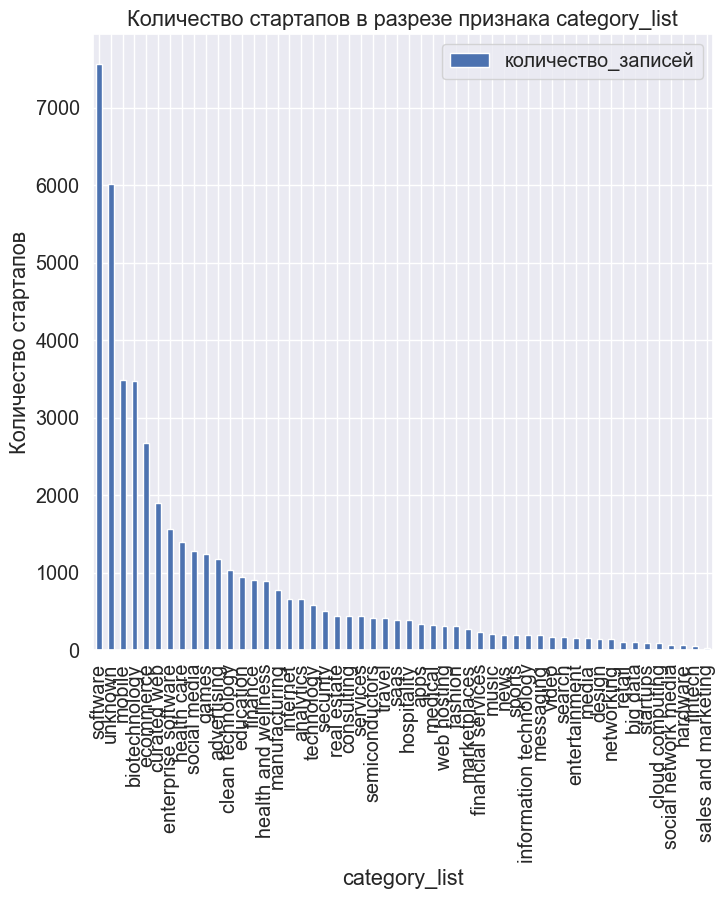

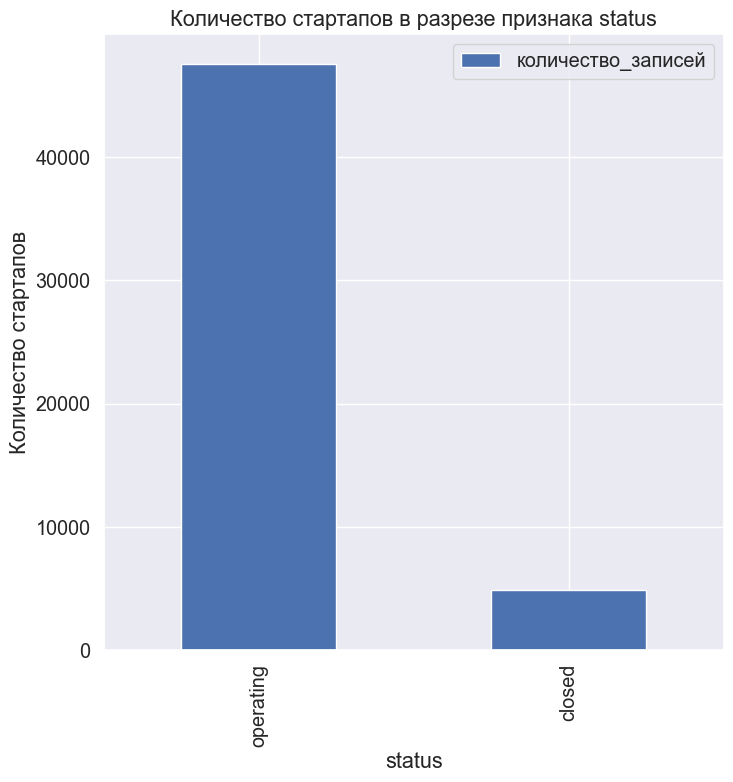

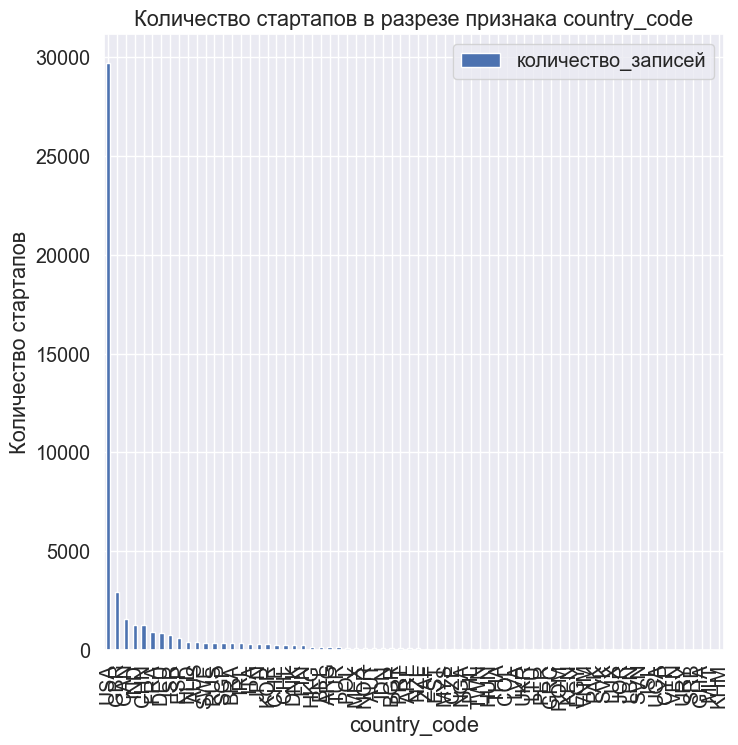

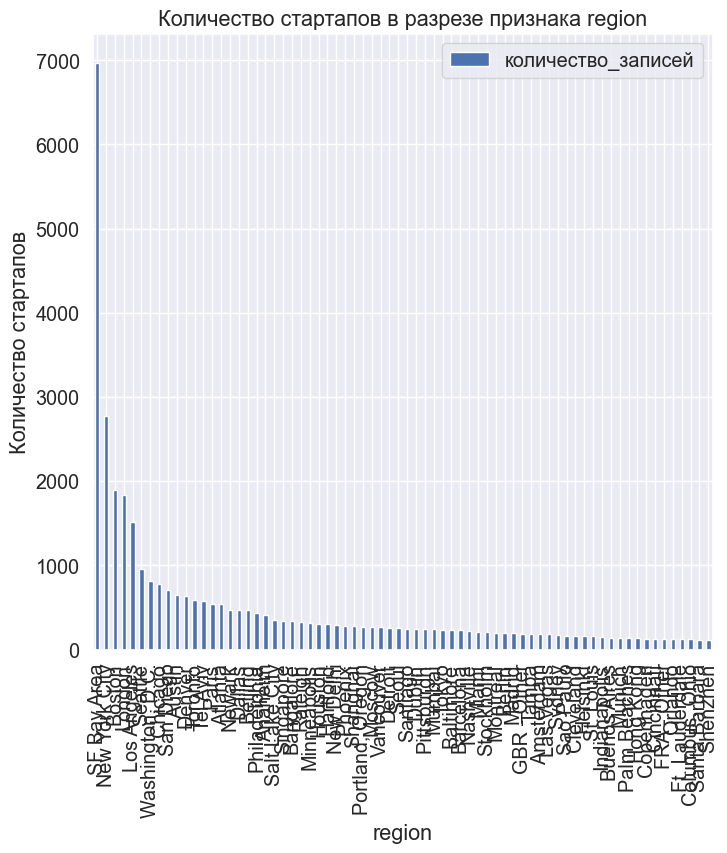

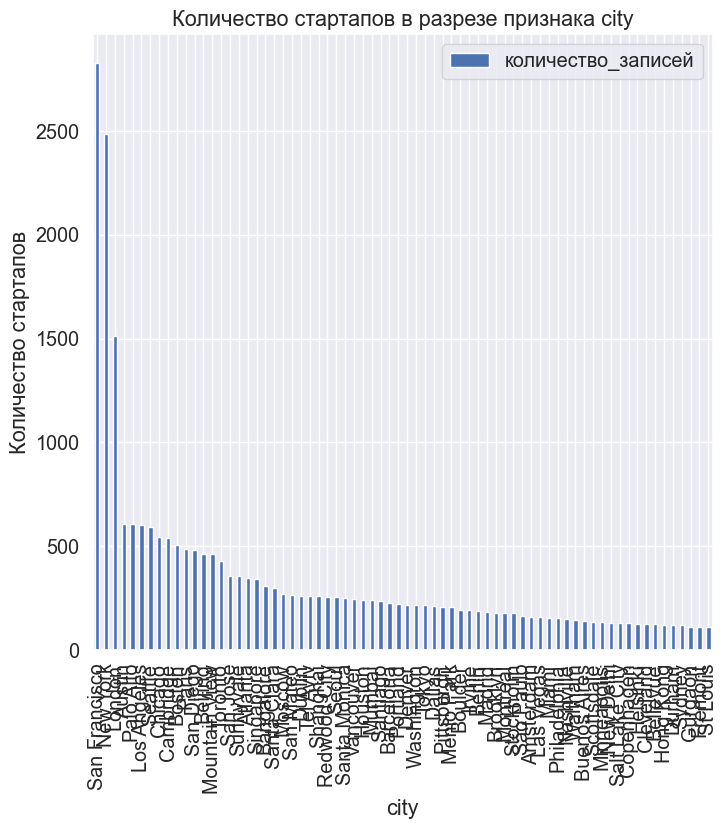

In [686]:
category_exploration(df_train, lst_cols)

<h3>Анализ стран, регионов, городов и штатов</h3>

In [687]:
def ex_cou_sr(df, limit):
    s1 = df_train['country_code'].value_counts()
    s2 = df_test['country_code'].value_counts()
    s = pd.concat([s1,s2])
    return list(s[s < limit].index)

In [688]:
def ex_reg_sr(df, limit):
    s = df_train['region'].value_counts()
    return list(s[s < limit].index)

In [689]:
def ex_state_sr(df, limit):
    s = df_train['state_code'].value_counts()
    return list(s[s < limit].index)

In [690]:
def ex_city_sr(df, limit):
    s = df_train['city'].value_counts()
    return list(s[s < limit].index)

In [691]:
def limit_df(df, ex_cou, ex_reg, ex_state, ex_city):
    df['country_code'] = df['country_code'].fillna("OTH")
    df['country_code'] = df['country_code'].apply(lambda x: 'OTH' if x in ex_cou else x) 
    
    df['region'] = df['region'].apply(lambda x: 'OTH' if x in ex_reg else x) 
    df['state_code'] = df['state_code'].apply(lambda x: 'OTH' if x in ex_state else x) 
    df['city'] = df['city'].apply(lambda x: 'OTH' if x in ex_city else x) 
    return df

In [692]:
ex_cou = ex_cou_sr(df_train, 50)
ex_reg = ex_reg_sr(df_train, 50)
ex_state = ex_state_sr(df_train, 50)
ex_city = ex_city_sr(df_train, 50)

In [693]:
display(df_train['country_code'].value_counts())
display(df_train['region'].value_counts())
display(df_train['state_code'].value_counts())

USA    29702
GBR     2925
CAN     1540
IND     1276
CHN     1240
       ...  
PSE        1
SEN        1
UZB        1
GRD        1
ZMB        1
Name: country_code, Length: 134, dtype: int64

SF Bay Area            6970
New York City          2776
Boston                 1890
London                 1840
Los Angeles            1513
                       ... 
Helena                    1
Castelfranco Veneto       1
Taunton                   1
Vevey                     1
Doncaster                 1
Name: region, Length: 1036, dtype: int64

CA    10219
NY     3112
MA     2020
TX     1562
H9     1510
      ...  
PE        1
Y1        1
O2        1
V3        1
U6        1
Name: state_code, Length: 300, dtype: int64

In [694]:
df_train = limit_df(df_train, ex_cou, ex_reg, ex_state, ex_city)

In [695]:
display(df_train['country_code'].value_counts())
display(df_train['region'].value_counts())
display(df_train['state_code'].value_counts())

USA    29702
OTH     8228
GBR     2925
CAN     1540
IND     1276
CHN     1240
FRA      916
DEU      834
ISR      767
ESP      607
NLD      380
AUS      379
SWE      373
RUS      369
SGP      356
BRA      355
IRL      351
ITA      321
JPN      314
KOR      300
CHE      262
CHL      252
DNK      242
FIN      227
Name: country_code, dtype: int64

OTH                    7541
SF Bay Area            6970
New York City          2776
Boston                 1890
London                 1840
                       ... 
Louisville               53
Jacksonville             53
Tallinn                  51
Pune                     50
Rochester, New York      50
Name: region, Length: 125, dtype: int64

CA     10219
NY      3112
OTH     2235
MA      2020
TX      1562
       ...  
36        57
ID        56
B8        54
VT        53
78        51
Name: state_code, Length: 90, dtype: int64

In [696]:
df_test = limit_df(df_test, ex_cou, ex_reg, ex_state, ex_city)

In [697]:
display(df_test['country_code'].value_counts())
display(df_test['region'].value_counts())
display(df_test['state_code'].value_counts())

USA    7428
OTH    2066
GBR     725
CAN     369
IND     307
CHN     301
DEU     237
FRA     213
ISR     190
ESP     134
AUS     120
NLD     112
JPN      93
SGP      91
RUS      87
BRA      85
IRL      83
CHL      80
ITA      79
SWE      75
CHE      69
DNK      68
KOR      61
FIN      52
Name: country_code, dtype: int64

OTH              1832
SF Bay Area      1750
New York City     712
London            481
Boston            460
                 ... 
Picardie            1
JOR - Other         1
Castelldefels       1
South Grafton       1
SÃ¨te               1
Name: region, Length: 179, dtype: int64

CA     2552
NY      789
OTH     538
MA      487
TX      410
       ... 
J5        1
V9        1
O3        1
75        1
W3        1
Name: state_code, Length: 101, dtype: int64

Исходя из анализа стран, регионов, штатов и городов, установлено, что есть значительное число различных объектов. Принято решение к отдельной категории OTH отнести объекты с общим числом появлений < 50 

<h3>Новый признак</h3>

In [698]:
df_train.head(10)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,sec_category_list
0,Lunchgate,unknown,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT,unknown
1,EarLens,manufacturing,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT,unknown
2,Reviva Pharmaceuticals,biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT,unknown
3,Sancilio and Company,health care,22250000.0,operating,OTH,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT,unknown
4,WireTough Cylinders,manufacturing,NaN,operating,USA,VA,OTH,OTH,1,2010-05-12,2012-02-01,2012-02-01,NaT,unknown
5,Connected Sports Ventures,mobile,4300000.0,operating,USA,NJ,Newark,OTH,1,2011-04-16,2012-11-12,2012-11-12,NaT,unknown
6,Attensity,software,90000000.0,operating,USA,CA,SF Bay Area,Redwood City,1,2000-01-01,2014-05-14,2014-05-14,NaT,unknown
7,Mesh Networks,software,4300000.0,operating,USA,TX,Houston,Houston,1,2005-01-01,2014-11-09,2014-11-09,NaT,unknown
8,AngioScore,biotechnology,42000000.0,operating,USA,CA,SF Bay Area,Fremont,2,2003-01-01,2007-10-09,2011-04-20,NaT,unknown
9,Vidatronic,semiconductors,1250500.0,operating,USA,TX,Austin,OTH,2,2010-01-01,2011-08-23,2013-03-21,NaT,unknown


In [699]:
df_train['closed_at'] = pd.to_datetime(df_train['closed_at'].fillna('2018-01-01'))
df_train['lifetime'] = (df_train['closed_at'] - df_train['founded_at']).dt.days

In [700]:
df_train['lifetime'].head(5)

0    2998
1    4748
2    4383
3    5114
4    2791
Name: lifetime, dtype: int64

В тестовый датасет добавлено поле dateframe

<h3>Анализ количественных признаков</h3>

In [701]:
df_train.head(10)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,sec_category_list,lifetime
0,Lunchgate,unknown,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,2018-01-01,unknown,2998
1,EarLens,manufacturing,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2018-01-01,unknown,4748
2,Reviva Pharmaceuticals,biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,2018-01-01,unknown,4383
3,Sancilio and Company,health care,22250000.0,operating,OTH,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,2018-01-01,unknown,5114
4,WireTough Cylinders,manufacturing,NaN,operating,USA,VA,OTH,OTH,1,2010-05-12,2012-02-01,2012-02-01,2018-01-01,unknown,2791
5,Connected Sports Ventures,mobile,4300000.0,operating,USA,NJ,Newark,OTH,1,2011-04-16,2012-11-12,2012-11-12,2018-01-01,unknown,2452
6,Attensity,software,90000000.0,operating,USA,CA,SF Bay Area,Redwood City,1,2000-01-01,2014-05-14,2014-05-14,2018-01-01,unknown,6575
7,Mesh Networks,software,4300000.0,operating,USA,TX,Houston,Houston,1,2005-01-01,2014-11-09,2014-11-09,2018-01-01,unknown,4748
8,AngioScore,biotechnology,42000000.0,operating,USA,CA,SF Bay Area,Fremont,2,2003-01-01,2007-10-09,2011-04-20,2018-01-01,unknown,5479
9,Vidatronic,semiconductors,1250500.0,operating,USA,TX,Austin,OTH,2,2010-01-01,2011-08-23,2013-03-21,2018-01-01,unknown,2922


In [702]:
lst_cols = ['funding_total_usd', 'lifetime']

Статистическая информация по столбцу: funding_total_usd
count    4.244700e+04
mean     1.824748e+07
std      1.871173e+08
min      1.000000e+00
25%      3.360275e+05
50%      2.000000e+06
75%      1.000000e+07
max      3.007950e+10
Name: funding_total_usd, dtype: float64


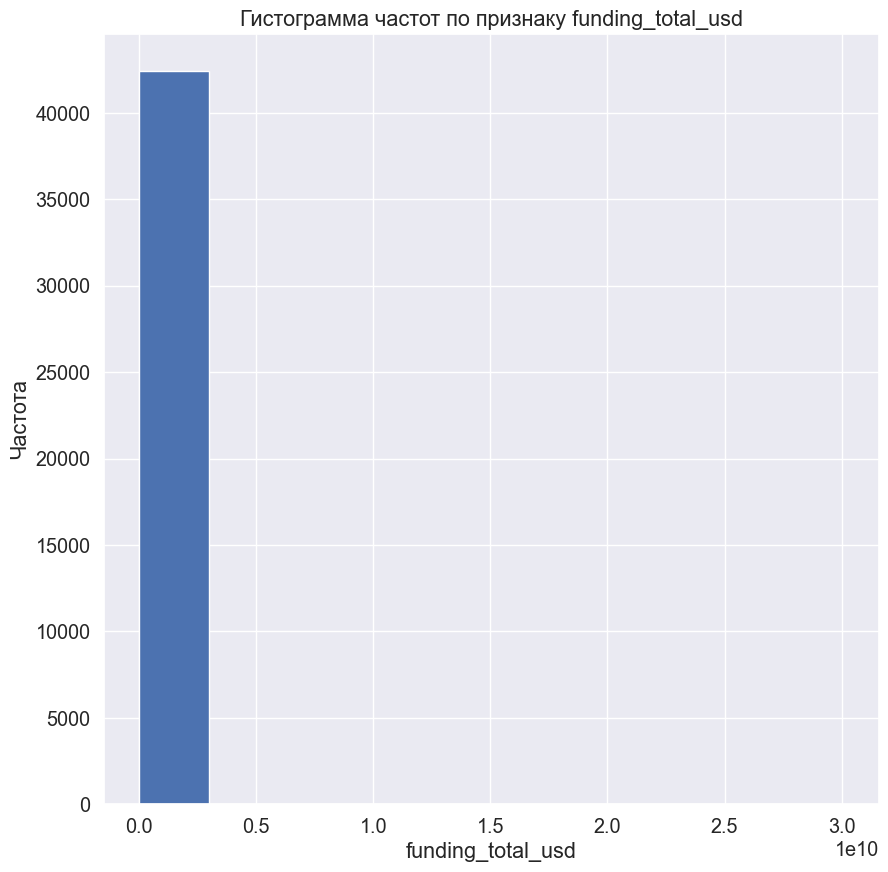

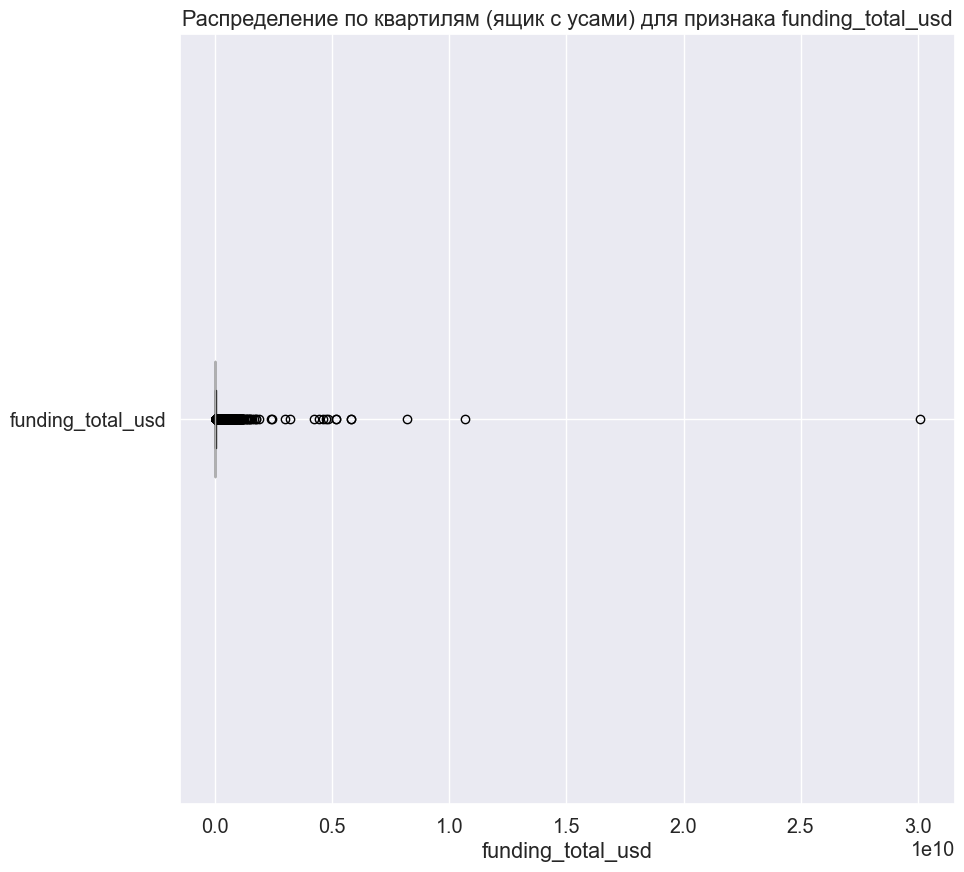

Статистическая информация по столбцу: lifetime
count    52516.000000
mean      3140.828129
std       2147.821070
min         19.000000
25%       1739.000000
50%       2557.000000
75%       4018.000000
max      17378.000000
Name: lifetime, dtype: float64


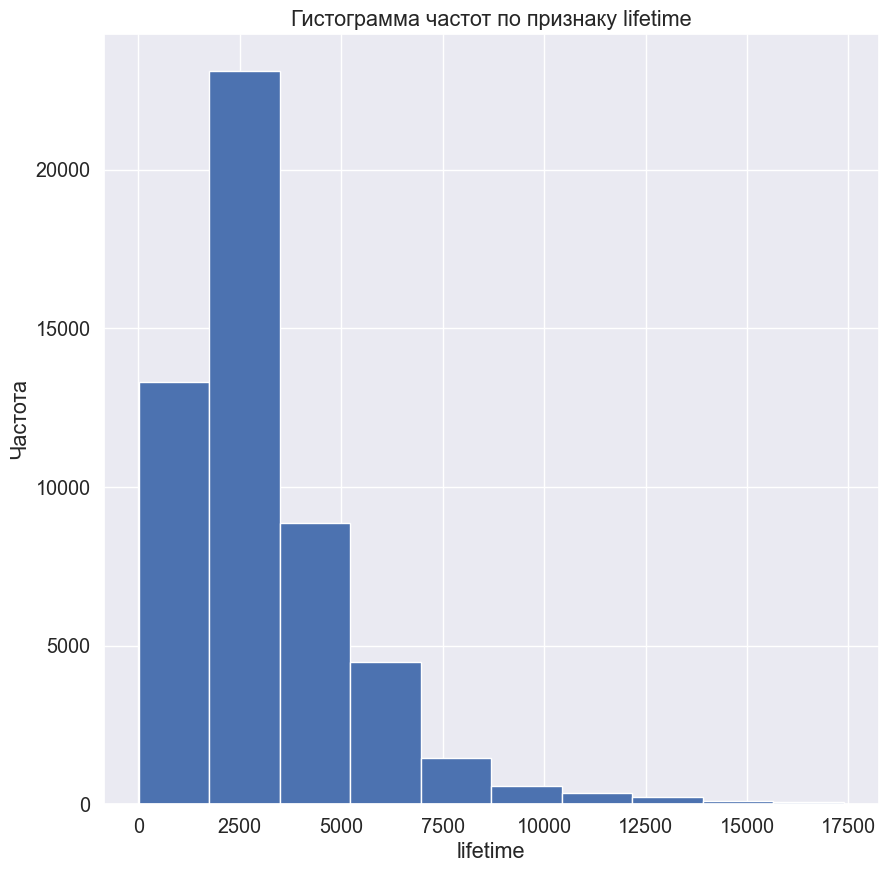

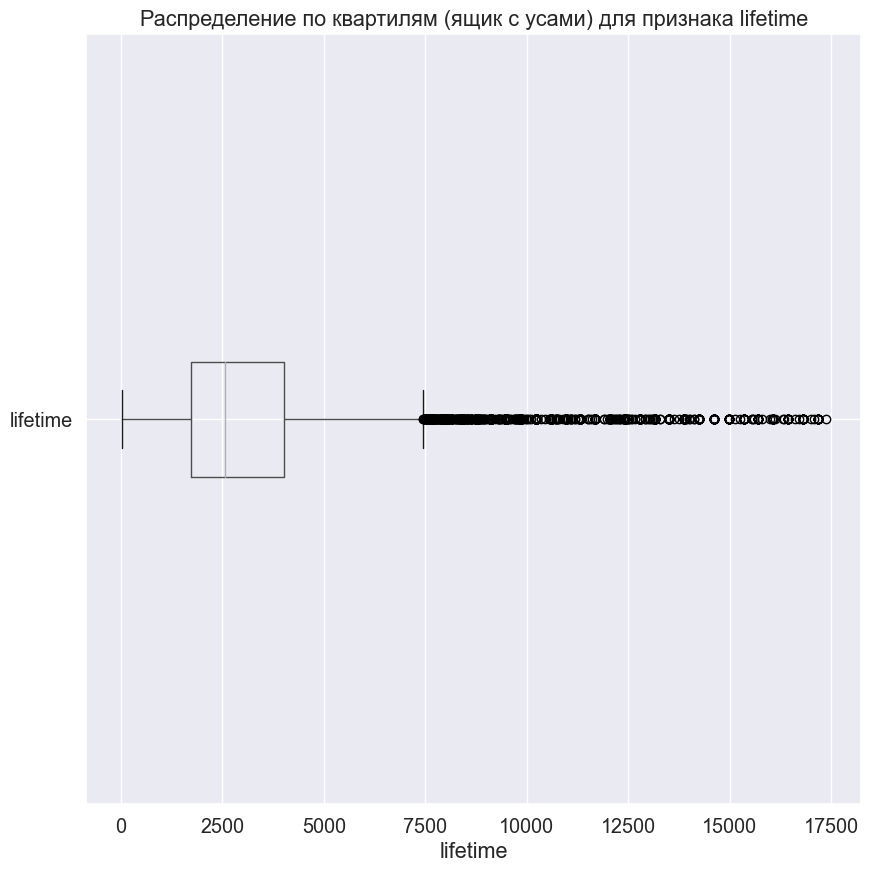

In [703]:
numeric_exploration(df_train, lst_cols)

In [704]:
df_train[df_train['funding_total_usd'] > 30000000000]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,sec_category_list,lifetime
39186,Verizon Communications,mobile,3.007950e+10,operating,USA,NY,New York City,New York,5,1983-10-07,2010-01-26,2014-02-28,2018-01-01,unknown,12505


In [705]:
df_train.loc[df_train['funding_total_usd'] > 30000000000, 'funding_total_usd'] = \
df_train['funding_total_usd'].median()

In [706]:
#df_train = df_train[~df_train['funding_total_usd'].isna()]
#df_test['funding_total_usd'] = df_test['funding_total_usd'].fillna(df_train['funding_total_usd'].mean())

In [707]:
df_train['funding_total_usd'] = df_train['funding_total_usd'].fillna(df_train['funding_total_usd'].mean())
df_test['funding_total_usd'] = df_test['funding_total_usd'].fillna(df_train['funding_total_usd'].mean())

In [708]:
df_train['freq_fund'] = df_train['funding_total_usd'] / df_train['lifetime']
df_test['freq_fund'] =  df_test['funding_total_usd'] / df_test['lifetime']

In [709]:
df_train['life_per_round'] = df_train['lifetime'] / df_train['funding_rounds']
df_test['life_per_round'] = df_test['lifetime'] / df_test['funding_rounds']

In [710]:
df_train['fundtime'] = (df_train['last_funding_at'] - df_train['first_funding_at']).dt.days
df_test['fundtime'] = (df_test['last_funding_at'] - df_test['first_funding_at']).dt.days

In [711]:
df_train['fund_per_round'] = df_train['funding_total_usd'] / (df_train['funding_rounds']+1)
df_test['fund_per_round'] = df_test['funding_total_usd'] / (df_test['funding_rounds']+1)

In [712]:
df_train['koef_funding'] = df_train['fundtime'] / (df_train['lifetime']+1)
df_test['koef_funding'] = df_test['fundtime'] / (df_test['lifetime']+1)

Для дальнейшего анализа добавлены дополнительные признаки.

<h3>Анализ дискретных признаков</h3>

Статистическая информация по столбцу: funding_rounds
count    52516.000000
mean         1.740670
std          1.374522
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         19.000000
Name: funding_rounds, dtype: float64
    funding_rounds  количество_записей  Percentage
0                1               33488   63.768447
1                2                9816   18.691802
2                3                4450    8.473769
3                4                2189    4.168333
4                5                1168    2.224126
5                6                 616    1.172998
6                7                 341    0.649338
7                8                 175    0.333238
8                9                 109    0.207560
9               10                  63    0.119966
10              11                  46    0.087594
11              12                  22    0.041893
12              13                   9    0.017138
13              14  

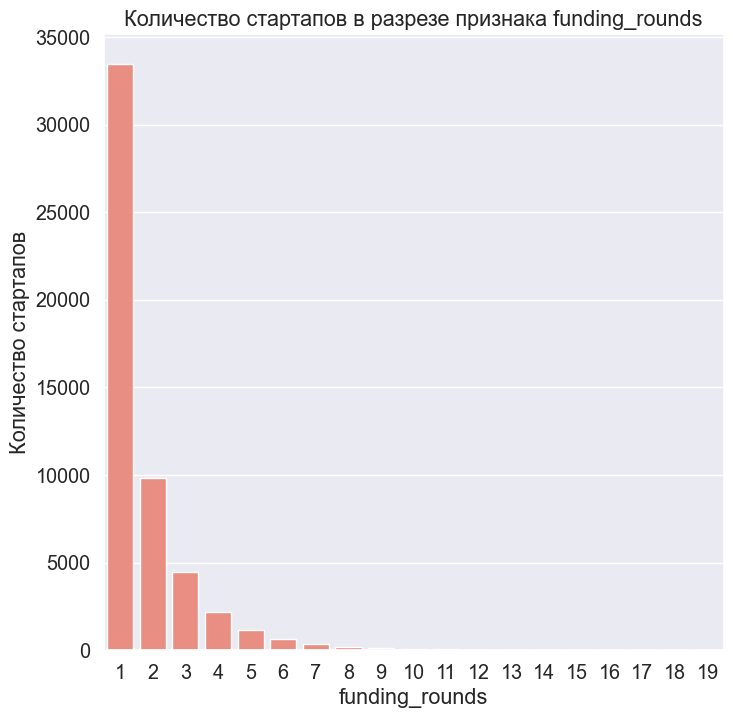

In [713]:
discrete_exploration(df_train, ['funding_rounds'])

Доп анализ

In [714]:
def Draw2(data, x_feature, y_feature, col):
    sns.set(font_scale=1.3)
    plt.xlabel(x_feature)
    plt.ylabel(y_feature)
    plt.gcf().set_size_inches(6, 6)
    sns.scatterplot(x=x_feature, y=y_feature, data=data, hue = col,  palette='bright', alpha=0.5)
   
    plt.show()
    

In [715]:
def Draw3(df, x_feature, x_name):
    df1 = df_train[df_train['status'] == 'operating']
    df2 = df_train[df_train['status'] == 'closed']
    sns.histplot(stat='density',common_norm=False, data=df1, x=x_feature, \
                alpha=0.5, bins=10, color='green', label='существующие стартапы')
    sns.histplot(stat='density', common_norm=False, color='blue', data=df2, x=x_feature, \
                 alpha=0.5, bins=10 , label='закрытые стартапы')
    plt.xlabel(x_name)
    plt.ylabel('Частота')
    plt.title('Сравнение распределений по признаку' + x_name)
    plt.grid(True)
    plt.rcParams["figure.figsize"] = (10,10)
    plt.legend()
    plt.show()

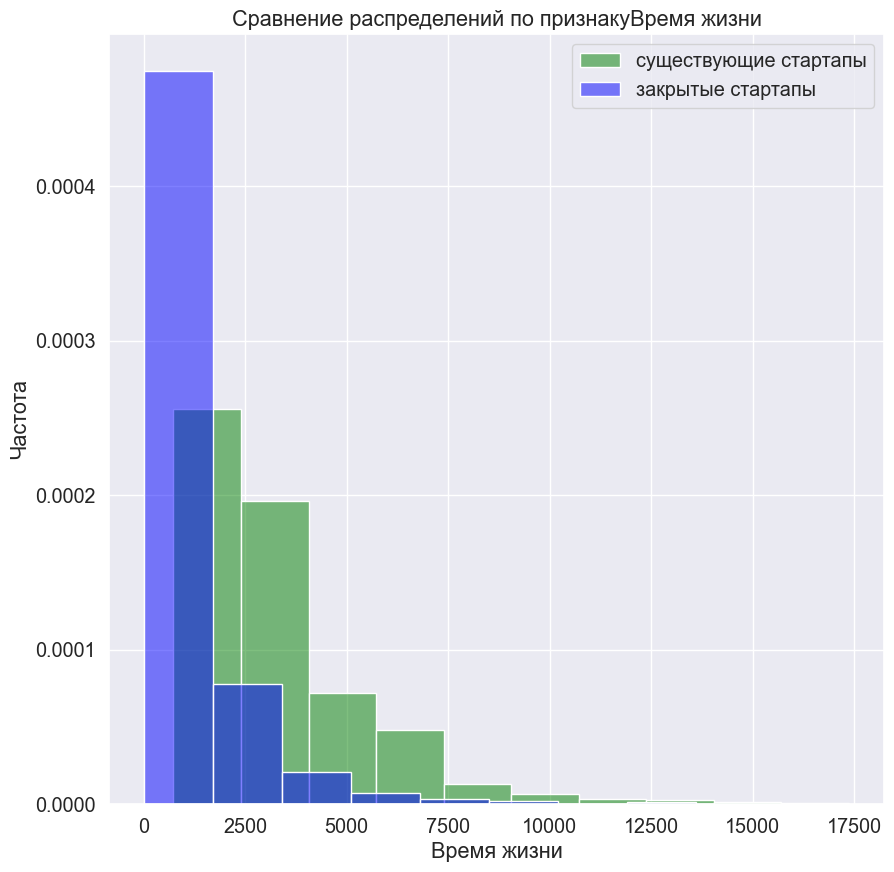

In [716]:
Draw3(df_train, "lifetime", "Время жизни")

In [717]:
df_op = df_train[df_train['status'] == 'operating']
df_cl = df_train[df_train['status'] == 'closed']

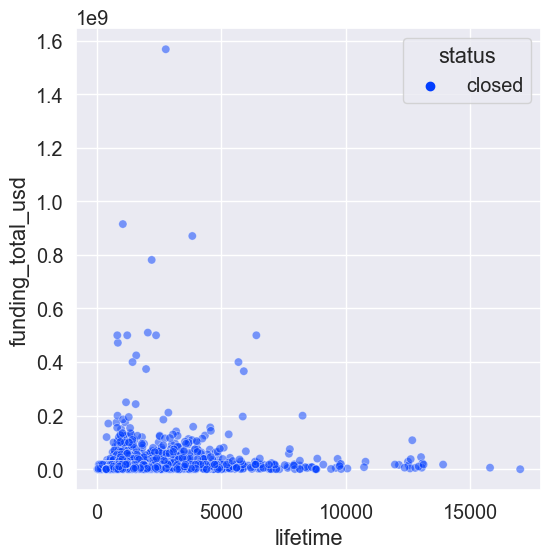

In [718]:
Draw2(df_cl, "lifetime", 'funding_total_usd', "status")

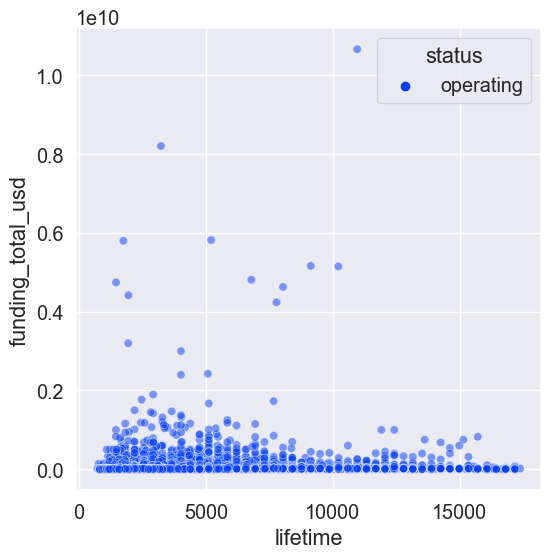

In [719]:
Draw2(df_op, "lifetime", 'funding_total_usd', "status")

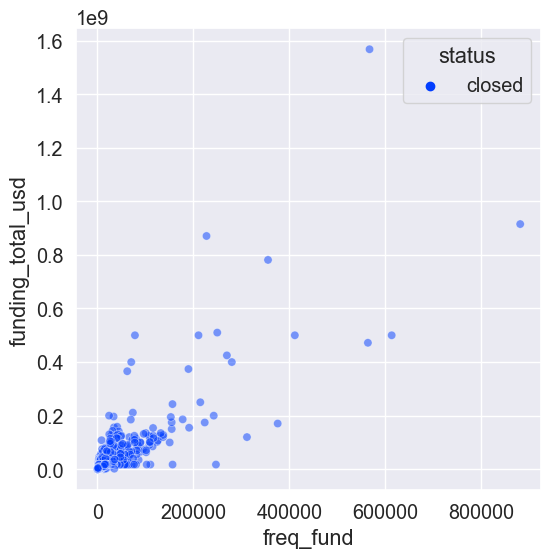

In [720]:
Draw2(df_cl, 'freq_fund', "funding_total_usd" , "status")

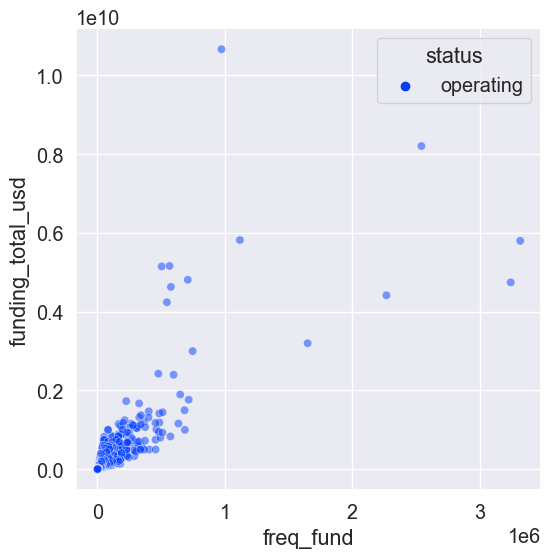

In [721]:
Draw2(df_op, 'freq_fund', "funding_total_usd" , "status")

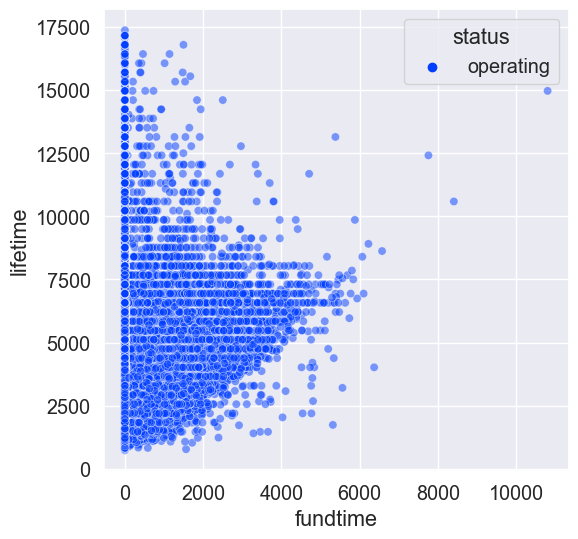

In [722]:
Draw2(df_op, 'fundtime', "lifetime" , "status")

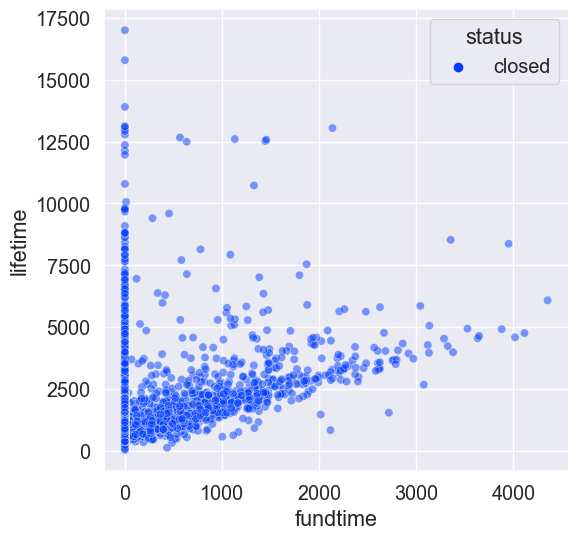

In [723]:
Draw2(df_cl, 'fundtime', "lifetime" , "status")

<br/> Время жизни закрытых стартапов составляет по большей части менее 2000 дней согалсно графикам распределений.
<br/>Чаще закрываются стартапы время жизни которых меньше 5000дней и сумма фонда меньше, чем 0,18*10e9.
<br/>Чаще закрываются стартапы с параметром freq_fund < 180000.
<br/> Чаще закрываются стартапы с временем фондирования fundtime меньшим 1000, при этом время жизни для них меньше 2500 дней.

<h3>Анализ корреляции</h3>

In [724]:
df_train_phik = df_train.sample(1000)

In [725]:
M1 = df_train_phik.phik_matrix(interval_cols=['funding_total_usd', 'lifetime', 'freq_fund', 'fund_per_round', 'life_per_round', 'fundtime', 'koef_funding'])
display(M1)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,sec_category_list,lifetime,freq_fund,life_per_round,fundtime,fund_per_round,koef_funding
name,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
category_list,1.0,1.000000,0.485569,0.146220,0.341873,0.000000,0.431387,0.261752,0.477183,0.000000,0.000000,0.687398,0.000000,0.000000,0.364674,0.586561,0.333529,0.000000,0.320288,0.000000
funding_total_usd,1.0,0.485569,1.000000,0.000000,0.000000,0.000000,0.323116,0.000000,0.596917,0.000000,0.764195,0.974794,0.000000,0.154751,0.229114,0.922884,0.269454,0.419534,0.856263,0.387210
status,1.0,0.146220,0.000000,1.000000,0.097974,0.000000,0.000000,0.000000,0.071763,0.337534,0.000000,0.702592,1.000000,0.038698,0.401019,0.163069,0.302781,0.077305,0.107074,0.103920
country_code,1.0,0.341873,0.000000,0.097974,1.000000,0.983034,0.992224,0.985247,0.000000,0.635895,0.000000,0.000000,0.000000,0.218449,0.000000,0.176313,0.000000,0.000000,0.011770,0.000000
state_code,1.0,0.000000,0.000000,0.000000,0.983034,1.000000,0.997912,0.994672,0.000000,0.434503,0.000000,0.000000,0.000000,0.000000,0.215335,0.000000,0.267977,0.000000,0.000000,0.000000
region,1.0,0.431387,0.323116,0.000000,0.992224,0.997912,1.000000,0.998753,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.174252,0.000000,0.000000,0.000000,0.000000,0.000000
city,1.0,0.261752,0.000000,0.000000,0.985247,0.994672,0.998753,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
funding_rounds,1.0,0.477183,0.596917,0.071763,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.180836,0.287976,0.678971,0.299429,0.703121,0.145701,0.738974
founded_at,1.0,0.000000,0.000000,0.337534,0.635895,0.434503,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.937491,0.465757,0.997841,0.805417,0.964021,0.000000,0.893084,0.000000


Высокая корреляция у прищнака Статус наблюдается с временем жизни, в меньшей степени категория и life_per_round. Даты из анализа исключаются.
Регион, штат, город имеют высокую корреляцию с со страной, поэтому исключаются.


<h2>Подготовка и обучение моделей</h2>

In [809]:
RANDOM_STATE = 5

In [810]:
df_train_prep = df_train.drop(['name', 'state_code', 'region','city',\
                        'founded_at', 'closed_at', 'first_funding_at', 'last_funding_at',\
                                'fund_per_round','life_per_round', 'koef_funding'], axis=1)
df_test_prep = df_test.drop(['name', 'state_code', 'region','city','first_funding_at', 'last_funding_at',\
                               'fund_per_round','life_per_round', 'koef_funding'], axis=1)


In [811]:
df_train_prep = df_train_prep.drop_duplicates()

In [812]:
X_train = df_train_prep.drop([ 'status'], axis=1)
data_info(X_train, "Тренировочная выборка")

Информация о столбцах таблицы  Тренировочная выборка
<class 'pandas.core.frame.DataFrame'>
Int64Index: 50535 entries, 0 to 52515
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   category_list      50535 non-null  object 
 1   funding_total_usd  50535 non-null  float64
 2   country_code       50535 non-null  object 
 3   funding_rounds     50535 non-null  int64  
 4   sec_category_list  50535 non-null  object 
 5   lifetime           50535 non-null  int64  
 6   freq_fund          50535 non-null  float64
 7   fundtime           50535 non-null  int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 3.5+ MB


None

Количество незаполненных значений в полях:
category_list        0
funding_total_usd    0
country_code         0
funding_rounds       0
sec_category_list    0
lifetime             0
freq_fund            0
fundtime             0
dtype: int64
Количество дубликатов: 35


In [813]:
y_train = df_train_prep['status']

In [814]:
X_test = df_test_prep
data_info(X_test, "Тестовая выборка")

Информация о столбцах таблицы  Тестовая выборка
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   category_list      13125 non-null  object 
 1   funding_total_usd  13125 non-null  float64
 2   country_code       13125 non-null  object 
 3   funding_rounds     13125 non-null  int64  
 4   lifetime           13125 non-null  int64  
 5   sec_category_list  13125 non-null  object 
 6   freq_fund          13125 non-null  float64
 7   fundtime           13125 non-null  int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 820.4+ KB


None

Количество незаполненных значений в полях:
category_list        0
funding_total_usd    0
country_code         0
funding_rounds       0
lifetime             0
sec_category_list    0
freq_fund            0
fundtime             0
dtype: int64
Количество дубликатов: 224


In [815]:
# создаем экземпляр класса LabelEncoder для кодирования целевого признака
label_encoder = LabelEncoder()
# обучаем модель и трансформируем тренировочную выборку 
y_train = label_encoder.fit_transform(y_train)

In [816]:
print(label_encoder.classes_)

['closed' 'operating']


In [817]:
# создаём списки с названиями признаков
ohe_columns = [ 'category_list', 'country_code', 'sec_category_list']
ord_columns = ['funding_rounds']
num_columns = [ 'lifetime', 'fundtime', 'freq_fund', 'funding_total_usd'] 

In [818]:
num_pipe = Pipeline(
    [('sc', MinMaxScaler()),
     ('num_fill_pipe', SimpleImputer(missing_values=np.nan, strategy='mean'))
    ]
    )

In [819]:
ord_pipe = Pipeline(
    [
    ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ('ord_fill_pipe', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [820]:
ohe_pipe = Pipeline(
    [
        ('none_fill_pipe', SimpleImputer(missing_values=np.nan,strategy='constant',\
                                    fill_value = 'Unknown')  ),  
        ('ohe', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='infrequent_if_exist'))
    ]
    )

In [821]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', num_pipe, num_columns)
    ], 
    remainder='passthrough'
)

# создаем итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        
        ('models', DecisionTreeClassifier( random_state=RANDOM_STATE, \
                     max_depth = 5, max_features = 25, min_samples_leaf = 3)  )                  
    
    ]
)

param_grid = [
             # словарь для модели DecisionTreeRegressor()
            {
                'models': [DecisionTreeClassifier( )],
                'models__max_depth': np.arange(3,15,2),
                'models__max_features': np.arange(5,80,2),
                'models__min_samples_leaf': np.arange(3,10,2),
                #'models__random_state': np.arange(1,10,1),
                #'preprocessor__num': [ MinMaxScaler()] #, StandardScaler(), 'passthrough'
            },  
    
          # словарь для модели LogisticRegression()
            {
                'models': [LogisticRegression(
                    random_state=RANDOM_STATE, 
                    solver='liblinear', 
                    penalty='l1'
                )],
                'models__C': np.arange(0.1,10.00,0.2),
                #'preprocessor__num': [MinMaxScaler(), 'passthrough']
            }
        ]

In [822]:
grid = GridSearchCV(
            pipe_final, 
            param_grid=param_grid, 
            cv=5, 
            scoring="f1", 
            #random_state=RANDOM_STATE, 
            n_jobs = -1,
            error_score='raise'
)

In [823]:
grid.fit(X_train, y_train) 

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('none_fill_pipe',
                                                                                          SimpleImputer(fill_value='Unknown',
                                                                                                        strategy='constant')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='infrequent_if_exist',
                                                                                                        sparse_output=False))]),
                                                                         ['category_list',
                                                                          'cou...
                          'models__min_samples_leaf': array([3, 5, 7, 9])},
                         {'models': [LogisticRegression(penalty='l1',
                                                        random_state=5,
                                                        solver='liblinear')],
                          'models__C': array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5,
       2.7, 2.9, 3.1, 3.3, 3.5, 3.7, 3.9, 4.1, 4.3, 4.5, 4.7, 4.9, 5.1,
       5.3, 5.5, 5.7, 5.9, 6.1, 6.3, 6.5, 6.7, 6.9, 7.1, 7.3, 7.5, 7.7,
       7.9, 8.1, 8.3, 8.5, 8.7, 8.9, 9.1, 9.3, 9.5, 9.7, 9.9])}],
             scoring='f1')

In [824]:
# проверяем работу модели на тестовой выборке
# рассчитываем прогноз на тестовых данных
y_train_pred = grid.predict(X_train)
display(y_train[0:100])
display(y_train_pred[0:100])
print(f'Метрика F1 на тренировочной выборке: {f1_score(y_train, y_train_pred)}')

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1])

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1])

Метрика F1 на тренировочной выборке: 0.9737589262668847


In [825]:
y_test_pred = grid.predict(X_test)

In [826]:
label_encoder.inverse_transform(y_test_pred)

array(['operating', 'operating', 'operating', ..., 'operating',
       'operating', 'operating'], dtype=object)

In [827]:
df_res = pd.DataFrame(df_test['name'])
df_res['status'] = label_encoder.inverse_transform(y_test_pred)
df_res.set_index('name', inplace=True)
df_res['status'].value_counts()

operating    12230
closed         895
Name: status, dtype: int64

In [828]:
df_res.to_csv("first.csv")

In [829]:
import winsound
winsound.Beep(440, 2000)

In [830]:
dummy_model = DummyClassifier(strategy="most_frequent")
dummy_model.fit(X_train, y_train)
dummy_model_preds = dummy_model.predict_proba(X_train)

print(f'Метрика F1 на тестовой выборке для константной модели: {f1_score(y_train, dummy_model_preds[:,1])}')

Метрика F1 на тестовой выборке для константной модели: 0.9494199825371087


<h2>Анализ результатов</h2>

In [831]:
best_pl = grid.best_estimator_
#best_pl = grid
X_test_scalled = pd.DataFrame(best_pl.named_steps['preprocessor'].transform(X_test))
X_train_scalled = pd.DataFrame(best_pl.named_steps['preprocessor'].transform(X_train))
best_model = best_pl.named_steps['models']
print(best_model)

DecisionTreeClassifier(max_depth=7, max_features=77, min_samples_leaf=5)


In [832]:
X_test_scalled.columns = [ x[5:30] for x in best_pl[:-1].get_feature_names_out()]
X_train_scalled.columns = X_test_scalled.columns
X_test_scalled.columns

Index(['category_list_analytics', 'category_list_apps',
       'category_list_big data', 'category_list_biotechnolo',
       'category_list_clean techn', 'category_list_cloud compu',
       'category_list_consulting', 'category_list_curated web',
       'category_list_design', 'category_list_ecommerce',
       'category_list_education', 'category_list_enterprise ',
       'category_list_entertainme', 'category_list_fashion',
       'category_list_finance', 'category_list_financial s',
       'category_list_fintech', 'category_list_games',
       'category_list_hardware', 'category_list_health and ',
       'category_list_health care', 'category_list_hospitality',
       'category_list_information', 'category_list_internet',
       'category_list_manufacturi', 'category_list_marketplace',
       'category_list_media', 'category_list_medical',
       'category_list_messaging', 'category_list_mobile',
       'category_list_music', 'category_list_networking', 'category_list_news',
       '

In [833]:
f = lambda x: best_model.predict_proba(x)[:,1]
med = X_train_scalled.median().values.reshape((1,X_train_scalled.shape[1]))
explainer = shap.KernelExplainer(f, med)
shap_values_norm = explainer.shap_values(X_test_scalled.iloc[0:1000,:], nsamples=1000)


  0%|          | 0/1000 [00:00<?, ?it/s]

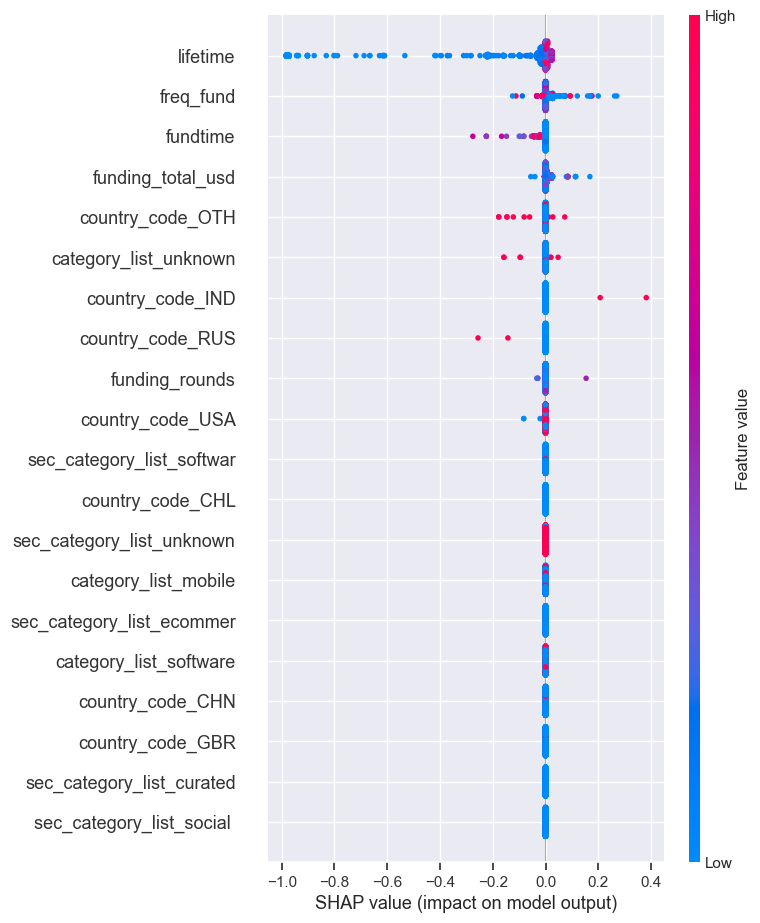

In [834]:
shap.summary_plot(shap_values_norm, X_test_scalled.iloc[0:1000,:], feature_names=X_train_scalled.columns)

In [835]:
shap_values = explainer(X_test_scalled.iloc[0:1000,:])

  0%|          | 0/1000 [00:00<?, ?it/s]

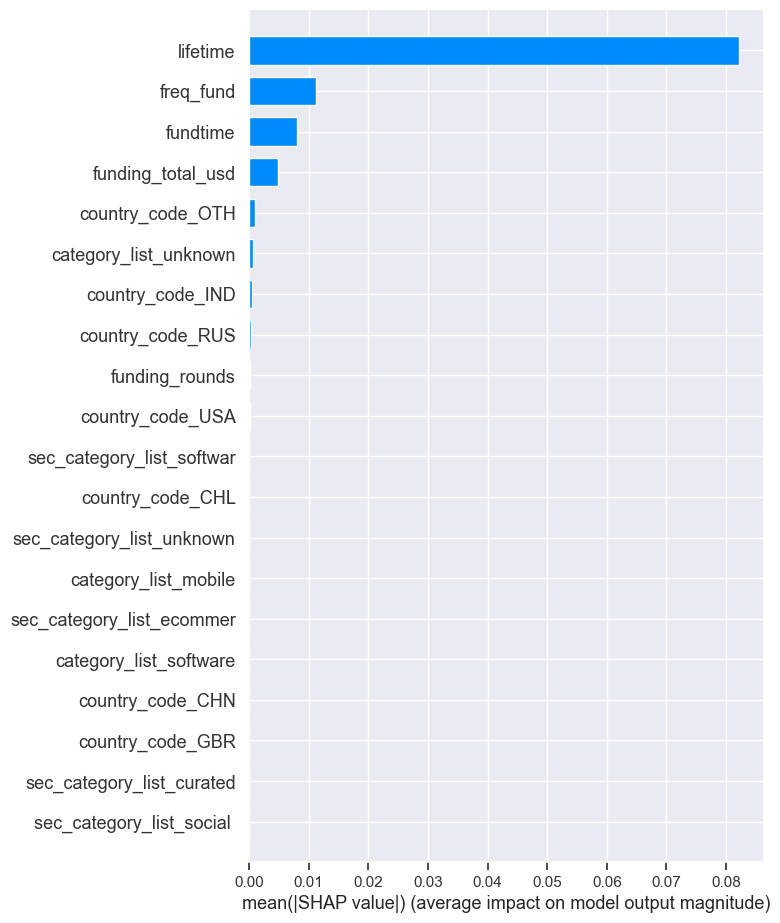

In [836]:
shap.summary_plot(shap_values_norm, X_test_scalled.iloc[0:1000,:], plot_type='bar', \
                  feature_names=X_train_scalled.columns, title = "SHAP Value Summary", max_display=20)

<br/>Наиболее важными признаками являются lifetime, freq_fund, fundtime, funding_total_usd, в меньшей степени отдельные страны и категории.
<br/>Чем меньше значение lifetime, тем выше вероятность принадлежности к классу closed, чем ниже значение freq_fund, тем выше вероятность принадлежности к классу operating.